### 70.単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．  

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．  

学習データの特徴量行列  
学習データのラベルベクトル  
検証データの特徴量行列  
検証データのラベルベクトル  
評価データの特徴量行列  
評価データのラベルベクトル  

In [24]:
from gensim.models import KeyedVectors

word_vector_path = '../chapter07/data/GoogleNews-vectors-negative300.bin'
word_vectors = KeyedVectors.load_word2vec_format(word_vector_path, binary=True)  # C bin format

In [4]:
train_path = '../chapter06/data_folder/train.txt'
dev_path = '../chapter06/data_folder/valid.txt'
test_path = '../chapter06/data_folder/test.txt'

train_out_x = 'data/train_out_x.pt'
train_out_y = 'data/train_out_y.pt'
dev_out_x = 'data/dev_out_x.pt'
dev_out_y = 'data/dev_out_y.pt'
test_out_x = 'data/test_out_x.pt'
test_out_y = 'data/test_out_y.pt'

In [16]:
import numpy as np
import torch
# from itertools import islice

def make_dataset(path, out_x, out_y):
    with open(path,'r') as f:
        matrix_x = []
        matrix_y = []
        label_id_dict = {'b': 0, 't': 1, 'e': 2, 'm': 3}
        
        for l in f:
            feature_vector = np.zeros(300)
            heading, label = l.strip().split('\t')
            words = heading.split(' ')
            
            unk_count = 0
            for w in words:
                if w in word_vectors:
                    feature_vector = feature_vector + word_vectors[w]
                # out of vocabの時はどうしよう？？
                elif not w in word_vectors:
#                     unk_count += 1
                    continue
                
            matrix_x.append(feature_vector / (len(words)))             
            matrix_y.append(label_id_dict[label])
        
        torch.save(torch.tensor(matrix_x), out_x)
        torch.save(torch.tensor(matrix_y), out_y)

In [82]:
make_dataset(train_path, train_out_x, train_out_y)
make_dataset(dev_path, dev_out_x, dev_out_y)
make_dataset(test_path, test_out_x, test_out_y)

In [83]:
# loadしてみる
out = torch.load(train_out_x)
print(type(out))
print(out.size())

<class 'torch.Tensor'>
torch.Size([10683, 300])


In [84]:
# loadしてみる
out = torch.load(train_out_y)
print(type(out))
print(out.size())

<class 'torch.Tensor'>
torch.Size([10683])


### 71.単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．  
ŷ 1=softmax(x1W)  
Ŷ =softmax(X[1:4]W)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 4)
        
    def forward(self, x):
        x = x.to(dtype=torch.float32)
        x = self.fc1(x)
        
        return x

In [105]:
net = Net()
train = torch.load(train_out_x)

print(train[:1].size())
F.softmax(net(train[:1]), dim=-1)

torch.Size([1, 300])


tensor([[0.2515, 0.2521, 0.2473, 0.2492]], grad_fn=<SoftmaxBackward>)

In [106]:
net = Net()
train = torch.load(train_out_x)

print(train[:4].size())
F.softmax(net(train[:4]), dim=-1)

torch.Size([4, 300])


tensor([[0.2513, 0.2496, 0.2494, 0.2497],
        [0.2543, 0.2489, 0.2455, 0.2513],
        [0.2509, 0.2482, 0.2526, 0.2483],
        [0.2517, 0.2501, 0.2495, 0.2488]], grad_fn=<SoftmaxBackward>)

### 72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．

In [107]:
CELoss = nn.CrossEntropyLoss()
net = Net()

vectors = torch.load(train_out_x)
labels = torch.load(train_out_y)

In [108]:
# vectors, labelsを[0] でスライスすると違う次元数が出てくる．[1,4]ではなく[4]，なぜ？
prob = net(vectors[:1])
loss = CELoss(prob, labels[:1])
loss.backward()

print(loss)
print(net.fc1.weight.grad)

tensor(1.3898, grad_fn=<NllLossBackward>)
tensor([[ 0.0034,  0.0021, -0.0052,  ..., -0.0036,  0.0035, -0.0037],
        [ 0.0031,  0.0019, -0.0048,  ..., -0.0033,  0.0032, -0.0034],
        [-0.0101, -0.0063,  0.0157,  ...,  0.0106, -0.0105,  0.0111],
        [ 0.0036,  0.0023, -0.0057,  ..., -0.0038,  0.0038, -0.0040]])


In [109]:
prob = net(vectors[:4])
loss = CELoss(prob, labels[:4])
loss.backward()

#複数事例に対するlossの平均になっているか？
print(loss)
print(net.fc1.weight.grad.size())
grads = net.fc1.weight.grad
print(grads)

tensor(1.3818, grad_fn=<NllLossBackward>)
torch.Size([4, 300])
tensor([[-0.0001, -0.0069, -0.0073,  ..., -0.0026,  0.0015,  0.0047],
        [ 0.0052,  0.0053, -0.0058,  ..., -0.0046,  0.0049, -0.0071],
        [-0.0112, -0.0048,  0.0198,  ...,  0.0127, -0.0122,  0.0108],
        [ 0.0061,  0.0063, -0.0068,  ..., -0.0055,  0.0058, -0.0084]])


## 73.確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [163]:
CELoss = nn.CrossEntropyLoss()
net = Net()

vectors = torch.load(train_out_x)
labels = torch.load(train_out_y)
print(vectors.size())
print(labels.size())

torch.Size([10683, 300])
torch.Size([10683])


In [164]:
import torch
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01)


def train(net, vectors, labels, max_epoch):
    for _ in range(max_epoch):
        for vector, label in zip(vectors, labels):   
            optimizer.zero_grad()
            
            logit = net(vector).view(1, 4)
            label = label.view(1)
            
            loss = CELoss(prob, label)
            loss.backward()
            optimizer.step() 

In [165]:
train(net, vectors, labels, 100)

In [166]:
torch.save(net.state_dict(), 'data/model_param')

## 74.正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [167]:
net = Net()
net.load_state_dict(torch.load('data/model_param'))
net.eval()

Net(
  (fc1): Linear(in_features=300, out_features=4, bias=True)
)

In [168]:
valid_vecs = torch.load(dev_out_x)
valid_labels = torch.load(dev_out_y)

test_vecs = torch.load(test_out_x)
test_labels = torch.load(test_out_y)

In [169]:
# 正解率を測る便利メソッドはpytorchにないのか？

def calc_accuracy(net, vectors, labels):
    total = 0
    count = 0
    for vector, label in zip(vectors, labels):
        logit = net(vector)
        pred = logit.argmax(-1)
        total += 1
        if pred == label:
            count += 1
    return count / total

In [170]:
calc_accuracy(net, dev_vecs, dev_labels)

0.899625468164794

In [171]:
calc_accuracy(net, test_vecs, test_labels)

0.8884730538922155

## 75.損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [192]:
valid_vecs = torch.load(dev_out_x)
valid_labels = torch.load(dev_out_y)

test_vecs = torch.load(test_out_x)
test_labels = torch.load(test_out_y)

In [1]:
def calc_accuracy_and_loss(net, vectors, labels):
    total = 0
    count = 0
    loss = 0
    for vector, label in zip(vectors, labels):
        logit = net(vector).view(1, 4)
        prob = F.softmax(net(logit), dim=-1)
        label = label.view(1)
        pred = prob.argmax(-1)
        
        total += 1
        loss += CELoss(prob, label)
        if pred == label:
            count += 1
    return count / total, loss / total

In [2]:
import torch
import torch.optim as optim

def train(net, vectors, labels, max_epoch, dev_vecs, dev_labels):
    net = Net()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    
    for epoch in range(max_epoch):
        for vector, label in zip(vectors, labels):   
            optimizer.zero_grad()
            
            prob = net(vector).view(1, 4)
            label = label.view(1)
            
            loss = CELoss(prob, label)
            loss.backward()
            optimizer.step() 
        yield calc_accuracy_and_loss(net, dev_vecs, dev_labels), epoch 

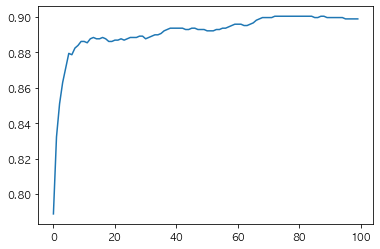

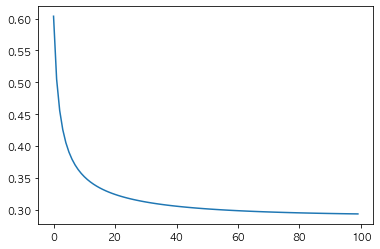

In [190]:
import matplotlib.pyplot as plt

accs = []
epoch_count = []
losses = []
for result, epoch in train(net, vectors, labels, 100, valid_vecs, valid_labels):
    accs.append(result[0])
    losses.append(result[1])
    epoch_count.append(epoch)
plt.plot(epoch_count, accs)
plt.show()
plt.plot(epoch_count, losses)
plt.show()

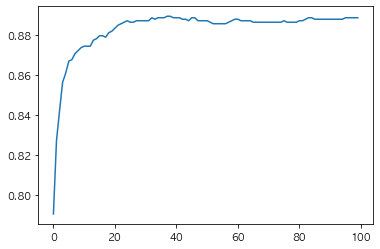

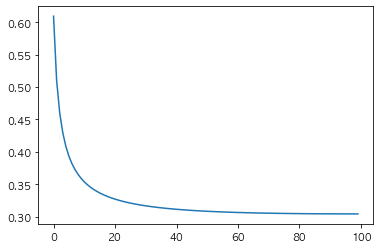

In [195]:
accs = []
epoch_count = []
losses = []
for result, epoch in train(net, vectors, labels, 100, test_vecs, test_labels):
    accs.append(result[0])
    losses.append(result[1])
    epoch_count.append(epoch)
plt.plot(epoch_count, accs)
plt.show()
plt.plot(epoch_count, losses)
plt.show()

## 76.チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [5]:
import torch

train_vecs = torch.load(train_out_x)
train_labels = torch.load(train_out_y)

valid_vecs = torch.load(dev_out_x)
valid_labels = torch.load(dev_out_y)

test_vecs = torch.load(test_out_x)
test_labels = torch.load(test_out_y)

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn

CELoss = nn.CrossEntropyLoss()

def train(vectors, labels, max_epoch, dev_vecs, dev_labels):
    net = Net()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    
    for epoch in range(max_epoch):
        for vector, label in zip(vectors, labels):   
            optimizer.zero_grad()
            
            logit = net(vector).view(1, 4)
            label = label.view(1)
            
            loss = CELoss(logit, label)
            loss.backward()
            optimizer.step() 
            torch.save({"epoch": epoch,
                        "model_state_dict": net.state_dict(), 
                        "optimizer_state_dict": optimizer.state_dict()},
                       f"data/model_params_Q76_epoch{epoch}")

In [12]:
train(train_vecs, train_labels, 10, valid_vecs, valid_labels)

In [13]:
param = torch.load("data/model_params_Q76_epoch1")
print(param)

{'epoch': 1, 'model_state_dict': OrderedDict([('fc1.weight', tensor([[-0.2032,  0.0160, -0.0543,  ...,  0.3872,  0.1812, -0.4355],
        [ 0.1093,  0.0133,  0.2025,  ..., -0.1149, -0.3017, -0.1220],
        [ 0.3109, -0.0221, -0.4186,  ..., -0.3655, -0.0569,  0.2824],
        [-0.2029,  0.0137,  0.2343,  ...,  0.0431,  0.2210,  0.2948]])), ('fc1.bias', tensor([ 0.1372, -0.2632,  0.8151, -0.6585]))]), 'optimizer_state_dict': {'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1]}]}}


## 77.ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [29]:
import numpy as np
import torch
from torch.utils.data import TensorDataset

def make_dataset(path, out):
    with open(path,'r') as f:
        matrix_x = []
        matrix_y = []
        label_id_dict = {'b': 0, 't': 1, 'e': 2, 'm': 3}
        
        for l in f:
            feature_vector = np.zeros(300)
            heading, label = l.strip().split('\t')
            words = heading.split(' ')
            
            unk_count = 0
            for w in words:
                if w in word_vectors:
                    feature_vector = feature_vector + word_vectors[w]
                # out of vocabの時はどうしよう？？
                elif not w in word_vectors:
                    continue
                
            matrix_x.append(feature_vector / (len(words)))             
            matrix_y.append(label_id_dict[label])
        
        torch.save(TensorDataset(torch.tensor(matrix_x), torch.tensor(matrix_y)), out)

In [30]:
train_out = 'data/train_dataset.pt'
dev_out = 'data/dev_dataset.pt'
test_out = 'data/test_dataset.pt'

make_dataset(train_path, train_out)
make_dataset(dev_path, dev_out)
make_dataset(test_path, test_out)

In [4]:
train_dataset = torch.load('data/train_dataset.pt')
print(train_dataset[0][0].size())
print(train_dataset[0][1].size())

torch.Size([300])
torch.Size([])


In [7]:
import torch
import torch.optim as optim
import torch.nn as nn

CELoss = nn.CrossEntropyLoss()

def train(data_loader, max_epoch):
    net = Net()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    
    for epoch in range(max_epoch):
        for vector, label in data_loader:
            optimizer.zero_grad()
            
            logit = net(vector)
            label = label
            
            loss = CELoss(logit, label)
            loss.backward()
            optimizer.step()

In [10]:
import timeit
from torch.utils.data import DataLoader

batch_sizes = [2**i for i in range(15)]
for batch_size in batch_sizes:
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    result = timeit.timeit('train(train_data_loader, 1)', globals=globals(), number=1)
    print(f'batch_size {batch_size}: {result}')

batch_size 1: 3.8994796690000157
batch_size 2: 1.8514386749999971
batch_size 4: 1.111813627999993
batch_size 8: 0.5853338440000186
batch_size 16: 0.3533190779999984
batch_size 32: 0.22472438099998726
batch_size 64: 0.170610245000006
batch_size 128: 0.15529918699999712
batch_size 256: 0.12407040099998312
batch_size 512: 0.132698591999997
batch_size 1024: 0.11992895999998154
batch_size 2048: 0.12560939600001575
batch_size 4096: 0.13268185699999435
batch_size 8192: 0.14682032600001094
batch_size 16384: 0.1514753029999838


## 78.GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [1]:
! cat data/time_count.txt

batch_size 1: 3.853148952126503
batch_size 2: 2.0314747355878353
batch_size 4: 1.0637329500168562
batch_size 8: 0.5789292026311159
batch_size 16: 0.33245150558650494
batch_size 32: 0.20701652765274048
batch_size 64: 0.14259298890829086
batch_size 128: 0.1109499279409647
batch_size 256: 0.09474338963627815
batch_size 512: 0.08515109121799469
batch_size 1024: 0.07828312553465366
batch_size 2048: 0.0752949882298708
batch_size 4096: 0.07641019485890865
batch_size 8192: 0.07665280811488628
batch_size 16384: 0.07785473577678204


## 79.多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [1]:
! cat data/result.txt

time:19.947740711271763, accuracy:0.9048689138576779/n